# Module 3: Analyzing Election Results and Polls

In [22]:
# Inline Chart Parameters
%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

# R imports
%load_ext rpy2.ipython

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

# Python Imports
import pandas as pd
import numpy as np
import us
from utils import download_pres_results
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [23]:
%%R

smartRequire <- function(pkg) {
  if (!require(pkg, character.only = T)) { install.packages(pkg, repos='http://cran.us.r-project.org') }
  require(pkg, character.only = T)
}

libs <- c("ggplot2", "theme538", "readr", "extrafont", "Cairo")
lapply(libs, smartRequire)
sprintf("Successfully loaded: %s", libs)


[1] "Successfully loaded: ggplot2"   "Successfully loaded: theme538" 
[3] "Successfully loaded: readr"     "Successfully loaded: extrafont"
[5] "Successfully loaded: Cairo"    


In [31]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Step 1: Download Data
- [Election Results](https://docs.google.com/spreadsheets/d/1D-edaVHTnZNhVU840EPUhz3Cgd7m39Urx7HM8Pq6Pus/edit#gid=29622862)
- Population Estimates By State
- [Polls](https://github.com/fivethirtyeight/data/tree/master/pollster-ratings)
- [Pollster Ratings](https://github.com/fivethirtyeight/data/tree/master/pollster-ratings)
- Census

## Election Results

In [30]:
pres_results_raw = download_pres_results()

def state_to_abbrev(state):
    return us.states.lookup(state).abbr
pres_results_national = pres_results_raw[pres_results_raw.state == 'Nationwide']
pres_results_by_state = pres_results_raw[~pres_results_raw.state.isin(['Washington DC','Nationwide'])]

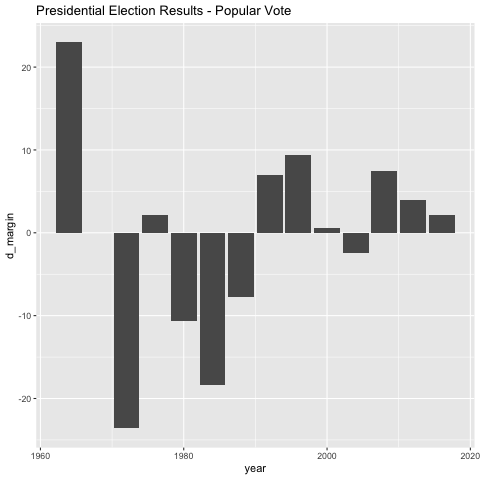

In [63]:
%%R -i pres_results_national
# pres_results_national
ggplot(data=pres_results_national,aes(x=year, y=d_margin)) + 
geom_bar(stat="identity") +
ggtitle("Presidential Election Results - Popular Vote")

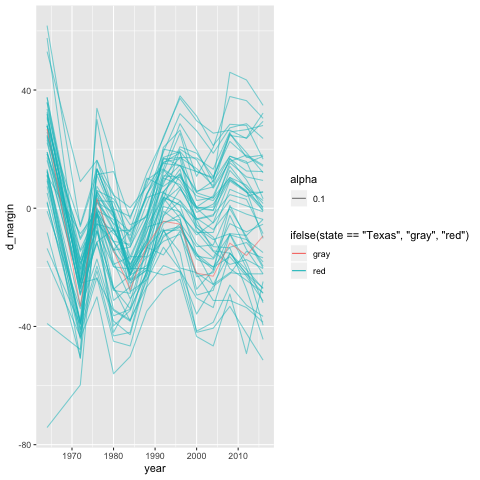

In [75]:
%%R -i pres_results_by_state

pres_results_by_state
ggplot(data=pres_results_by_state,aes(x=year, y=d_margin, group=state, alpha=.1,col = ifelse(state=='Texas','gray','red'))) + 
geom_line()

### Todo
- Calculate PVI
- Plot PVI

## 2016 Presidential Election Results

1. scatterplots with trendlines of election results verus census data a-la
https://fivethirtyeight.com/features/where-trump-got-his-edge/

2. a regression with like 3 or 4 variables
    - education (some college or higher vs not)
    - gender (men vs woman)
    - race (white vs nonwhite %)
    - income

## Polling Data vs Election Results

#### Step 1: Visualize (same chart different data)

- nationwide popular vote: polls versus election results for each year (x axis = year)
    1. plot
    2. look @ average error in table
- state by state polls vs popular vote for 2016 (x axis = state)
    1. plot
    2. look at average errors in table
- state by state average errors for each year (x axis = year)
    1. plot
    2. look at average errors in table

#### Step 2: Polling averages and adjustment

* state by state 2016 polls
    1. plot (x axis = state - plot each poll, average of polls, and election result)
    2. plot (x axis = state - plot each *adjusted* poll, *adjusted* average of polls, and election result)
    3. plot (x axis = state - plot average, adjusted average, and election result
* do the last chart with national 2016 as well as national for all years

In [78]:
polls = pd.read_csv('raw-polls.csv')
pollster_ratings = pd.read_csv('pollster-ratings.csv')

*Presidential Polls*

Exercise 1: Particular Polls vs Average of the Polls (2016 only, then all)

Exercise 2: Adjusted Average of the Polls (2016 only, then all)

Exercise 3: Average polling error in 2016 (compared to past years)


In [19]:
def state_to_abbrev(state):
    return us.states.lookup(state).abbr

pres_results_national = pres_results[pres_results.state == 'Nationwide']
pres_polls_national = polls[(polls.type_detail=='Pres-G') & (polls.location == 'US')]

In [4]:
pres_results = pres_results[~pres_results.state.isin(['Washington DC','Nationwide'])]
pres_results['state_abbrev'] = pres_results.state.apply(state_to_abbrev)
pres_results['race'] =  pres_results.year.astype('str') + '_Pres-G_' + pres_results.state_abbrev
pres_results.head()

,DEM,REP,PVI,year,state,d_margin,state_abbrev,race
2,35.599998,64.400002,R+15.0,2016,Alabama,-28.800003,AL,2016_Pres-G_AL
3,41.599998,58.400002,R+9.0,2016,Alaska,-16.800003,AK,2016_Pres-G_AK
4,48.099998,51.900002,R+3.0,2016,Arizona,-3.800003,AZ,2016_Pres-G_AZ
5,35.700001,64.300003,R+15.0,2016,Arkansas,-28.600002,AR,2016_Pres-G_AR
6,66.099998,33.900002,D+15.0,2016,California,32.199997,CA,2016_Pres-G_CA


In [11]:
pres_polls = polls[(polls.type_detail=='Pres-G') & ~(polls.location == 'US')]